<a href="https://colab.research.google.com/github/RuslanMavlitov/IDE/blob/master/Uplift_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Оценка аплифт-эффекта от рекламных предложений на примере французского рекламного агентства "criteo"

## Загрузка и обработка данных
 


### Установка библиотек

In [6]:
!git clone https://github.com/uber/causalml.git
!cd causalml
!pip install -r /content/causalml/requirements.txt
!pip install causalml

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split


# Импортируем S- и T-learner`ы (BaseSClassifier и BaseTClassifier) из библиотеки CausalML
from causalml.inference.meta import BaseSClassifier, BaseTClassifier

# Импортируем X- и R-learner`ы (BaseXClassifier и BaseRClassifier) из библиотеки CausalML
from causalml.inference.meta import BaseXClassifier, BaseRClassifier

# Продолжаем решать нашу постановку как задачу классификации - для этого возьмем одно Uplift-дерево и случайный лес
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

# В качестве классификатора применим стандартную Логистическую регрессию и Линейную регрессию для модели Х-learner
from sklearn.linear_model import LogisticRegression, LinearRegression

ModuleNotFoundError: ignored

### Загрузка и обработка данных 

In [7]:
data =  pd.read_csv("/content/criteo-uplift-v2.1.csv.gz")
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [8]:
print(data.shape)
data.info()

(13979592, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


Вот подробное описание полей (в файле они разделены запятыми):

**f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11** : значения признаков(float64)

**treatment** : группа обработки (1 = обработанная, 0 = контрольная)

**conversion** : произошла ли конверсия для этого пользоваеля (1 = да, 0 = нет)

**visit** : произошло ли посещение для этого пользователя (1 = да, 0 = нет)

**exposure** : эффект обработки, был ли пользователь подвергнут эффективному воздействию (1 = да, 0 = нет)

### Анализ признака воздействия на клиентов

In [28]:
data['treatment'].value_counts(normalize=True)*100

1    85.000013
0    14.999987
Name: treatment, dtype: float64

<Axes: ylabel='treatment'>

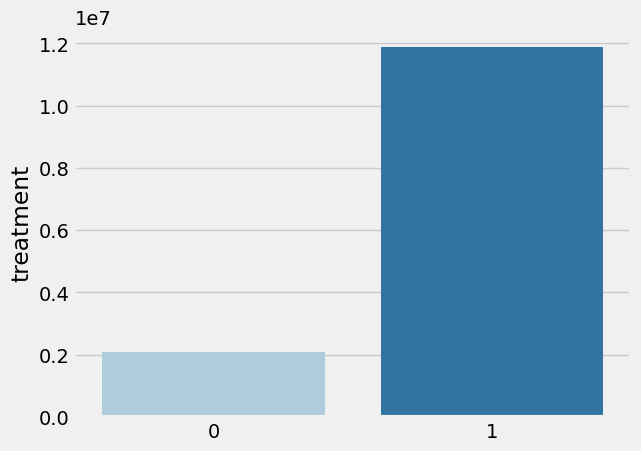

In [15]:
sns.barplot(x=data['treatment'].value_counts().index, y=data['treatment'].value_counts())

Видно, что распределение по воздействию сильно расбалансированно. 85% клиентов были подвергнуты воздействию.

### Анализ признака конверсии клиентов

In [38]:
data['conversion'].value_counts(normalize=True)*100

0    99.708332
1     0.291668
Name: conversion, dtype: float64

Положительная конверсия не превышает 0,3%!!!

<Axes: ylabel='conversion'>

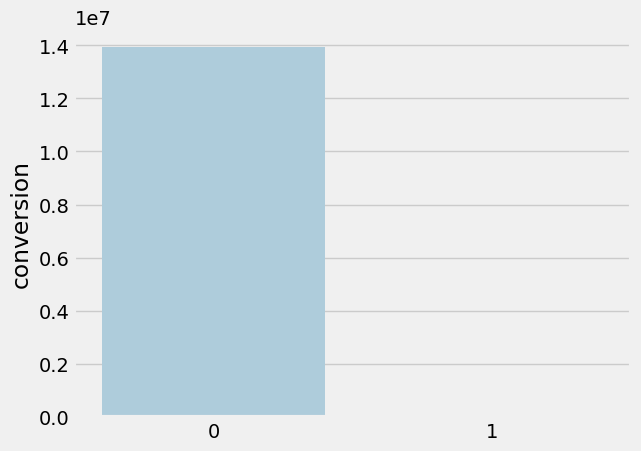

In [18]:
sns.barplot(x=data['conversion'].value_counts().index, y=data['conversion'].value_counts())

In [39]:
#Посмотрим влияние воздействия ("treatment") на клиентов на конверсию
pivot = pd.pivot_table(data,
               index=["treatment"],
               values=["conversion"],
               aggfunc=np.sum)
pivot

,conversion
treatment,
0,4063
1,36711


Видно, большинство клиентов с положительной конверсией это клиенты на которых было воздействие. 

### Подготовка данных

In [8]:
#удалим признаки visit, exposure
data.drop(['visit', 'exposure'], axis=1, inplace=True)

#разделим данные на тренировочную и тестовую выборку
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10','f11']
target_col = 'conversion'
treatment_col = 'treatment'

df_train, df_test = train_test_split(data, stratify=data[[treatment_col, target_col]], random_state=42, test_size=0.2)

In [9]:
# Реализуем подсчит qini скора:
def qini_df(df, title='train', figsize=(5, 3)):
    # 1. Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['target_class'] <= 1)
    N_t = sum(ranked['target_class'] >= 2)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.target_class == 1,'n_c1'] = 1
    ranked.loc[ranked.target_class == 3,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # Немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    quni_score = (ranked['uplift'] - ranked['random_uplift']).sum()
    print('Qini score: {:.3f}'.format(quni_score))

## S-learner (CausalML)

In [ ]:
s_learner = BaseSClassifier(learner=LogisticRegression(random_state=42))

s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = s_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

## T-learner (CausalML)


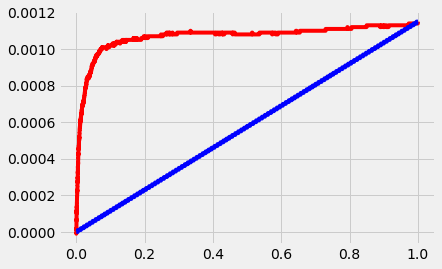

1378.9237300000011

In [ ]:
t_learner = BaseTClassifier(learner=LogisticRegression(random_state=42))

t_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = t_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

 ## X-learner (CausalML)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

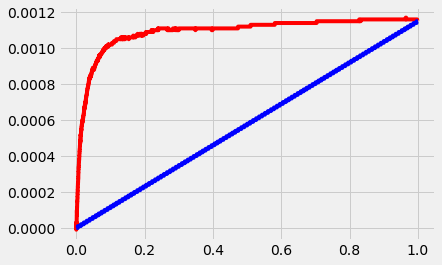

1443.80931

In [ ]:
x_learner = BaseXClassifier(outcome_learner=LogisticRegression(random_state=42),
                           effect_learner=LinearRegression())

x_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = x_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

 ## R-learner (CausalML)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

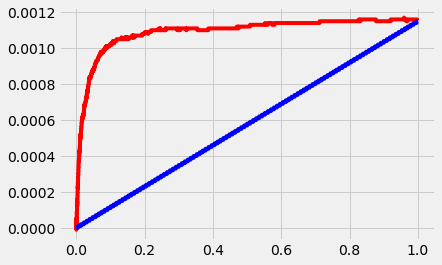

1442.1268800000005

In [ ]:
r_learner = BaseRClassifier(outcome_learner=LogisticRegression(random_state=42),
                            effect_learner=LinearRegression())

r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = r_learner.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))
df_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

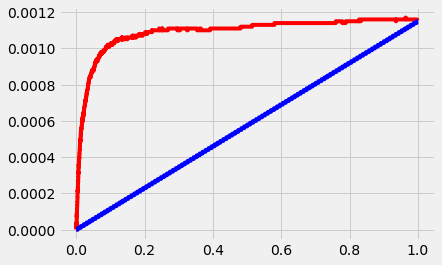

1441.4074499999992

In [ ]:
r_learner = BaseRClassifier(outcome_learner=LogisticRegression(random_state=42),
                            effect_learner=LinearRegression())

r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))

test_tmp = df_test.copy()
test_tmp['uplift_score'] = uplift_vals
qini_df(test_tmp)

## Uplift-tree (CausalML)

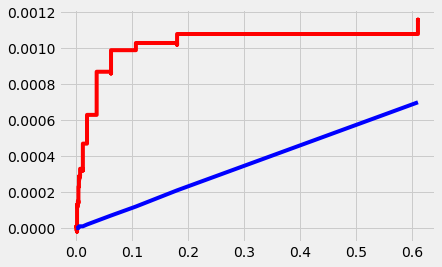

1422.9462600000004

In [ ]:
uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0', random_state=42)

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = uplift_tree.predict(np.array(df_train[feature_cols].values.copy()))[:, 1]
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = uplift_tree.predict(np.array(df_test[feature_cols].values.copy()))[:, 1]
df_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

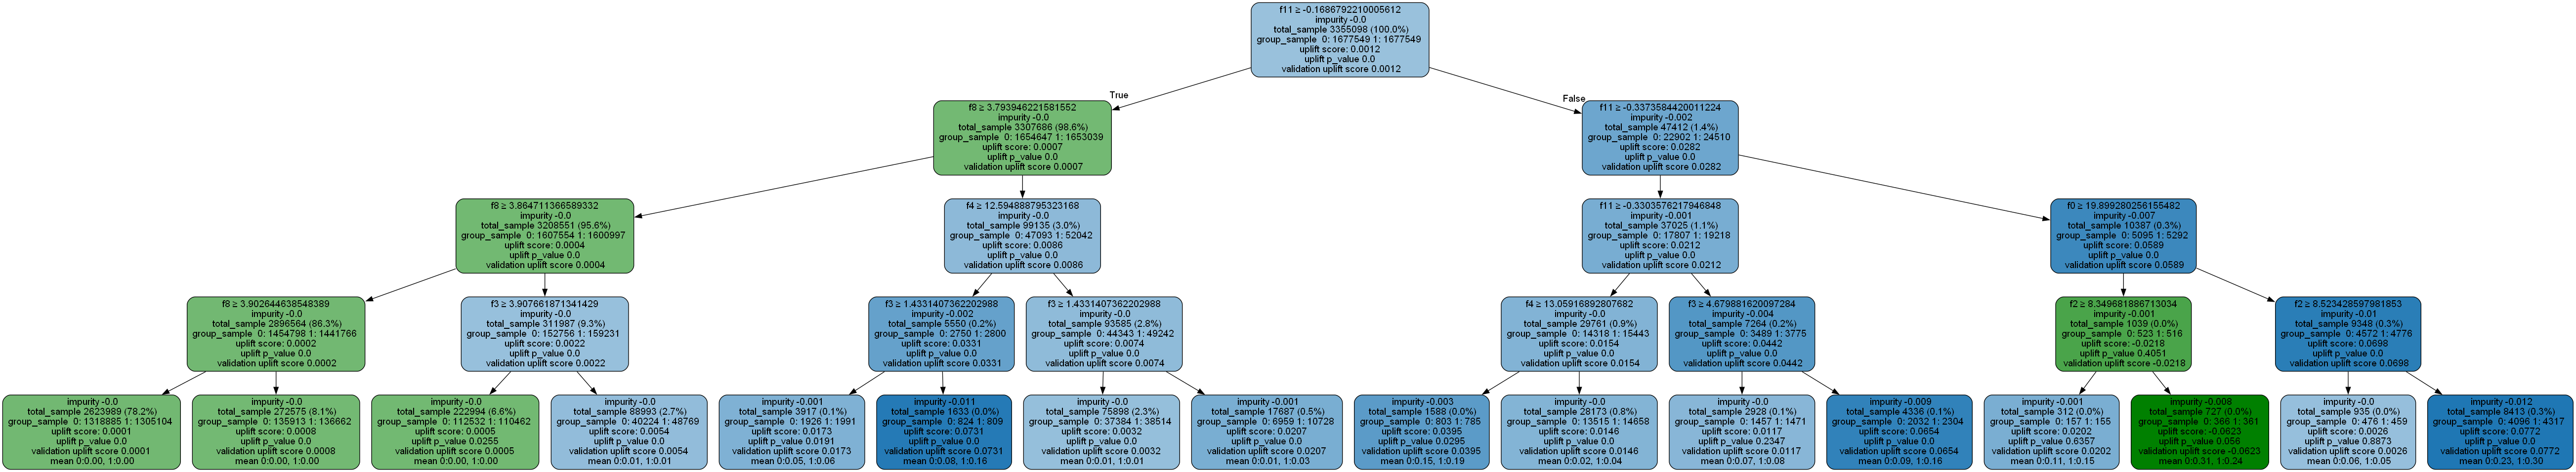

In [ ]:
from IPython.display import Image
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, feature_cols)
Image(graph.create_png())

## UpliftRandomForest (CausalML)

In [ ]:
uplift_model = UpliftRandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0', random_state=42)

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
uplift_forest.fit(
    df_train[feature_cols].values,
    treatment=df_train[treatment_col].apply(str).values,
    y=df_train[target_col].values
)

# Сделаем предсказание uplift-эффекта на обучающей выборке
uplift_vals = uplift_forest.predict(np.array(df_train[feature_cols].values.copy()))
df_train['uplift_score'] = uplift_vals

# Сделаем предсказание uplift-эффекта на тестовой выборке
uplift_vals = uplift_forest.predict(np.array(df_discount_test[feature_cols].values.copy()))
df_discount_test['uplift_score'] = uplift_vals

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
qini_df(df_train, title='train')
qini_df(df_test, title='test')

### Вывод: 

простроены оценки аплифт-эффекта от рекламных предложений для различных алгоритмов.
Наибольшую точность показа алгоритм T-learner на базе алгоритма CatBoostClassifier


PS Будет неплохо - если проверяющий подскажет, что можно было улучшить! 